In [1]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from src.data import data_layer
from src.model.model_utils import calculateStatistics
from src.model.model_GAN import FeedForwardModelWithNA_GAN_Ensembled
from src.model.model_RtnFcst import FeedForwardModelWithNA_Return_Ensembled
from src.utils import deco_print
from src.utils import load_dataframe
from src.utils import sharpe
from src.utils import max_1_month_loss
from src.utils import max_drawdown
from src.utils import eval_RtnFcst
from src.utils import construct_decile_portfolios
from src.utils import plot_decile_portfolios
from src.utils import plot_SMV
from src.utils import plot_SDF
from src.utils import plotReturnDecile
from src.utils import OLS
from src.utils import GRS
from src.utils import calculateStatisticsDecile
from src.utils import calculateStatisticsDoubleSorted5
from src.utils import calculateTurnover_with_dl

c:\Users\TJR\anaconda3\envs\tf112\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\TJR\anaconda3\envs\tf112\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\TJR\anaconda3\envs\tf112\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\TJR\anaconda3\envs\tf112\lib\site-packages\tensorflow\python\framework

In [2]:
print(tf.__version__)

1.12.0


Note that the newest version of matplotlib may have some bug in plotting Contour Slice plots, and we used 3.1.3 version for the plots

In [3]:
print(matplotlib.__version__)

3.1.3


Below is a sample of the first step training for the main SDF network for a single run of one set of hyperparameters. This roughly takes 4 hours on my Intel i9 CPU ( and takes less than 3 hours on a Nvidia Titan V GPU with the CUDA version of Tensorflow).

As specified in Table A.I of the paper, we ran search on 384 sets of hyper-parameters (labeled by task_id). Then for the top candidates we further ran 8 more trials for ensemble results (labelled by trial_id).

For easier replication, we have provided 9 trials of sample checkpoints with the hyperparameter sets we used in the paper. These sample checkpoints are newly trained and are different from the ones we used to generate the results in the paper. Due to the randomness from Tensorflow model weights initialization, it is expected that the metrics and not 100% identical from run to run. But from our tests the differences are reasonably small. As an example, in table 1 we reported 0.75 testing Sharpe ratio for the GAN model, but this sample checkpoints give 0.77. These small differences are within margin of error and do not change the conclusions we draw in the paper.

In [4]:
# !python run.py --config=config/config.json --logdir=output --saveBestFreq=128 --printOnConsole=True --saveLog=True --ignoreEpoch=32  --task_id 1 --trial_id 0

##### Model Configurations

In [5]:
'''
RetChar: individual features, firm-month data
Macro: macroeconomic features, monthly data

'''

'\nRetChar: individual features, firm-month data\nMacro: macroeconomic features, monthly data\n\n'

In [6]:
task_id = 1
logdir = 'sample_checkpoints'
logdirs = [logdir + '/Task_%d_Trial_%d/sharpe' %(task_id, k) for k in range(9)]
with open('config/config.json') as file:
    config = json.load(file)

##### Load Data

In [7]:
ind = np.load(config['individual_feature_file'])

for name, array in ind.items():
    print(name, array.shape)

date (240,)
variable (47,)
data (240, 3686, 47)


In [8]:
ind['variable']

array(['ret', 'A2ME', 'AC', 'AT', 'ATO', 'BEME', 'Beta', 'C', 'CF',
       'CF2P', 'CTO', 'D2A', 'D2P', 'DPI2A', 'E2P', 'FC2Y', 'IdioVol',
       'Investment', 'Lev', 'LME', 'LT_Rev', 'LTurnover', 'MktBeta', 'NI',
       'NOA', 'OA', 'OL', 'OP', 'PCM', 'PM', 'PROF', 'Q', 'r2_1', 'r12_2',
       'r12_7', 'r36_13', 'Rel2High', 'Resid_Var', 'RNA', 'ROA', 'ROE',
       'S2P', 'SGA2S', 'Spread', 'ST_REV', 'SUV', 'Variance'],
      dtype='<U10')

In [9]:
'''
data_layer.DataInRamInputLayer creates a data layer object that reads data
this day layer object is used to feed data to the model
'''

dl = data_layer.DataInRamInputLayer(config['individual_feature_file'],
                                    pathMacroFeature=config['macro_feature_file'])
meanMacroFeature, stdMacroFeature = dl.getMacroFeatureMeanStd()
dl_valid = data_layer.DataInRamInputLayer(config['individual_feature_file_valid'],
                                          pathMacroFeature=config['macro_feature_file_valid'],
                                          meanMacroFeature=meanMacroFeature,
                                          stdMacroFeature=stdMacroFeature)
dl_test = data_layer.DataInRamInputLayer(config['individual_feature_file_test'],
                                         pathMacroFeature=config['macro_feature_file_test'],
                                         meanMacroFeature=meanMacroFeature,
                                         stdMacroFeature=stdMacroFeature)

In [22]:
dl._macroFeature.shape, dl._individualFeature.shape, dl._return.shape, dl._mask.shape


((240, 178), (240, 3686, 46), (240, 3686), (240, 3686))

In [12]:
dl._mask

array([[ True,  True, False, ..., False, False, False],
       [ True,  True, False, ..., False, False, False],
       [ True,  True, False, ..., False, False, False],
       ...,
       [False, False,  True, ..., False,  True,  True],
       [False, False,  True, ..., False,  True,  True],
       [False, False,  True, ...,  True,  True,  True]])

In [27]:
dl._return # you can see the return data has many -9999 values, which are the missing values
dl._mask # mask data is 1 if the return data is not missing, 0 otherwise
np.sum(dl._mask, axis=1) # number of non-missing values for each firm-month, this is use for normalization of weigth and SDF

array([[ 1.36223e-01,  3.17129e-01, -9.99900e+01, ..., -9.99900e+01,
        -9.99900e+01, -9.99900e+01],
       [-3.97030e-02, -3.60000e-03, -9.99900e+01, ..., -9.99900e+01,
        -9.99900e+01, -9.99900e+01],
       [ 1.52727e-01, -5.79540e-02, -9.99900e+01, ..., -9.99900e+01,
        -9.99900e+01, -9.99900e+01],
       ...,
       [-9.99900e+01, -9.99900e+01,  8.14760e-02, ..., -9.99900e+01,
         1.62067e-01,  1.27380e-01],
       [-9.99900e+01, -9.99900e+01, -1.56650e-02, ..., -9.99900e+01,
         1.38957e-01, -3.08060e-02],
       [-9.99900e+01, -9.99900e+01, -1.68050e-02, ..., -3.12592e-01,
        -4.90000e-03,  1.35330e-02]])

In [28]:
np.sum(dl._mask, axis=1).cumsum()

array([   430,    860,   1291,   1727,   2162,   2599,   3152,   3914,
         4681,   5455,   6231,   7009,   7789,   8572,   9350,  10132,
        10923,  11722,  12624,  13527,  14434,  15351,  16273,  17201,
        18135,  19075,  20021,  20970,  21930,  22897,  23894,  24898,
        25908,  26924,  27943,  28968,  29998,  31030,  32069,  33113,
        34160,  35211,  36273,  37333,  38378,  39430,  40513,  41602,
        42702,  43803,  44906,  46012,  47109,  48216,  49360,  50506,
        51652,  52820,  53994,  55172,  56354,  57541,  58728,  59918,
        61115,  62319,  63561,  64798,  66044,  67305,  68573,  69805,
        71042,  72331,  73624,  74925,  76229,  77535,  78861,  80197,
        81536,  82883,  84234,  85593,  86960,  88330,  89711,  91105,
        92507,  93911,  95318,  96732,  98145,  99572, 100996, 102406,
       103827, 105253, 106684, 108132, 109593, 111061, 112535, 113961,
       115389, 116867, 118349, 119831, 121277, 122738, 124184, 125557,
      

##### Load Model

In [10]:
tf.reset_default_graph() # reset the graph
global_step = tf.train.get_or_create_global_step()
'''
get the global step, global step is a variable in machine learing model that keeps track of the number of batches that have been processed
it is used to keep track of the number of training iterations
for example, as the model trains, the global step will increase by 1 for each batch of data that is processed
the learing rate can be adjusted based on the global step, for example, the learning rate can be decreased as the global step increases
'''

# the following code creates the model for later use
model = FeedForwardModelWithNA_GAN_Ensembled(logdirs, config, 'test', config['tSize'], global_step=global_step)
model_valid = FeedForwardModelWithNA_GAN_Ensembled(logdirs, config, 'test', config['tSize_valid'], force_var_reuse=True, global_step=global_step)
model_test = FeedForwardModelWithNA_GAN_Ensembled(logdirs, config, 'test', config['tSize_test'], force_var_reuse=True, global_step=global_step)
model_plot = FeedForwardModelWithNA_GAN_Ensembled(logdirs, config, 'plot', 1, force_var_reuse=True, global_step=global_step)

# following code is used for setting GPU options for training
gpu_options = tf.GPUOptions(allow_growth=True)
sess_config = tf.ConfigProto(gpu_options=gpu_options)
sess = tf.Session(config=sess_config)

In [11]:
'''
logdirs: a list of directories where the model checkpoints are saved
model params: [config] a dictionary of contains amost all the parameters for the model
'''

'\nlogdirs: a list of directories where the model checkpoints are saved\nmodel params: [config] a dictionary of contains amost all the parameters for the model\n'

In [12]:
INITIAL_train = model.getZeroInitialState()
'''
generate initial state of the model for each checkpoint, according to models's number of cells and number of units in each layer
relate to config['cell_type_rnn'], config['num_units_rnn']
for train model, the initial state are all zeros with the shape of [1, sum(config['num_units_rnn'])]
'''

# the following model's initial state is generated based on the previous model's initial state
INITIAL_valid = model.getNextInitialState(sess, dl, initial_state=INITIAL_train)
INITIAL_test = model_valid.getNextInitialState(sess, dl_valid, initial_state=INITIAL_valid)


INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_0/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_1/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_2/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_3/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_4/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_5/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_6/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkp

In [13]:
print(INITIAL_train)

[array([[0., 0., 0., 0., 0., 0., 0., 0.]]), array([[0., 0., 0., 0., 0., 0., 0., 0.]]), array([[0., 0., 0., 0., 0., 0., 0., 0.]]), array([[0., 0., 0., 0., 0., 0., 0., 0.]]), array([[0., 0., 0., 0., 0., 0., 0., 0.]]), array([[0., 0., 0., 0., 0., 0., 0., 0.]]), array([[0., 0., 0., 0., 0., 0., 0., 0.]]), array([[0., 0., 0., 0., 0., 0., 0., 0.]]), array([[0., 0., 0., 0., 0., 0., 0., 0.]])]


In [14]:
print(INITIAL_valid)

[array([[-0.81568015, -0.30937487,  1.725673  , -0.45642465, -0.38435668,
        -0.03129893,  0.67353874, -0.08466906]], dtype=float32), array([[ 0.17483892,  0.161909  , -0.60915387,  0.1402544 ,  0.11059027,
         0.08180777, -0.17122754,  0.08387184]], dtype=float32), array([[-1.1667047e+00, -7.4511749e-01,  3.7276745e-04, -1.6411583e-01,
        -1.9683041e-01, -1.4630546e-01,  2.1803257e-04, -5.7551488e-02]],
      dtype=float32), array([[0.01224622, 0.01512399, 0.43638825, 1.1716905 , 0.00188659,
        0.00452771, 0.33332977, 0.3551329 ]], dtype=float32), array([[ 0.08484045,  0.34431946, -0.44739753,  0.187862  ,  0.02565459,
         0.20372112, -0.22809103,  0.10464483]], dtype=float32), array([[-0.4340623 ,  0.23196611,  0.5402396 ,  1.1763918 , -0.18252721,
         0.04533656,  0.20590933,  0.33736593]], dtype=float32), array([[-0.28623372, -0.14308888, -0.1914709 , -1.1538231 , -0.02641397,
        -0.02475348, -0.10809851, -0.11546025]], dtype=float32), array([[ 1.

##### Model Performance

In [15]:
w = model.getWeightWithData(sess, dl, initial_state=INITIAL_train, normalized=True)
w_valid = model_valid.getWeightWithData(sess, dl_valid, initial_state=INITIAL_valid, normalized=True)
w_test = model_test.getWeightWithData(sess, dl_test, initial_state=INITIAL_test, normalized=True)

'''
w shape is [9, 336113]
meaning for [1, 336113] for each checkpoint
why 336113? Because there are 336113 firm-months in the training data, and the weight is calculated for each firm-month
the 336113 will be further split into 240 months, where each firm-montn will be assigned a weight to calculate SDF
'''

INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_0/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_1/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_2/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_3/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_4/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_5/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_6/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkp

array([[-3.3635601e-08, -3.2803391e-07,  6.7159147e-07, ...,
         3.3105019e-07, -4.2711636e-07, -3.1184076e-08],
       [-5.4869628e-07, -1.7921069e-07,  4.1688506e-07, ...,
        -1.1905162e-09,  1.9878169e-07, -4.2387302e-07],
       [-4.0639628e-07, -4.5765603e-07,  4.6010823e-07, ...,
        -4.1911012e-08,  1.3471099e-07, -1.7789783e-07],
       ...,
       [-3.6243867e-07, -5.2534705e-08, -1.2800868e-07, ...,
        -5.6271108e-07,  1.7321085e-07, -1.5231390e-07],
       [-3.2148122e-07, -1.8758313e-09,  1.1923760e-07, ...,
         3.4773606e-08,  1.6460565e-07, -3.0479214e-07],
       [-4.0798975e-07,  8.3212754e-08, -6.1090377e-09, ...,
         1.5834438e-08, -5.0221792e-07, -3.3057736e-07]], dtype=float32)

In [12]:
Ftrain = model.getNormalizedSDFFactor(sess, dl, initial_state=INITIAL_train)
Fvalid = model_valid.getNormalizedSDFFactor(sess, dl_valid, initial_state=INITIAL_valid)
Ftest = model_test.getNormalizedSDFFactor(sess, dl_test, initial_state=INITIAL_test)
sdf_norm_ensemble = np.concatenate([Ftrain, Fvalid, Ftest])
np.save(os.path.join(logdir, 'sdf_normalized_ensemble.npy'), sdf_norm_ensemble)

>==================> WARNING: Checkpoint not found! Use random initialization! 
>==================> Random initialization
>==================> WARNING: Checkpoint not found! Use random initialization! 
>==================> Random initialization
>==================> WARNING: Checkpoint not found! Use random initialization! 
>==================> Random initialization
>==================> WARNING: Checkpoint not found! Use random initialization! 
>==================> Random initialization
>==================> WARNING: Checkpoint not found! Use random initialization! 
>==================> Random initialization
>==================> WARNING: Checkpoint not found! Use random initialization! 
>==================> Random initialization
>==================> WARNING: Checkpoint not found! Use random initialization! 
>==================> Random initialization
>==================> WARNING: Checkpoint not found! Use random initialization! 
>==================> Random initialization
>===============

Sharpe ratio results for GAN reported in Table I

In [13]:
SR_train = sharpe(Ftrain)
SR_valid = sharpe(Fvalid)
SR_test = sharpe(Ftest)
deco_print('SDF Portfolio Sharpe Ratio: Train %0.2f\tValid %0.2f\tTest %0.2f' %(SR_train, SR_valid, SR_test))

>==================> SDF Portfolio Sharpe Ratio: Train 0.11	Valid 0.10	Test 0.22


### Variable Importance ### 
Figure 11

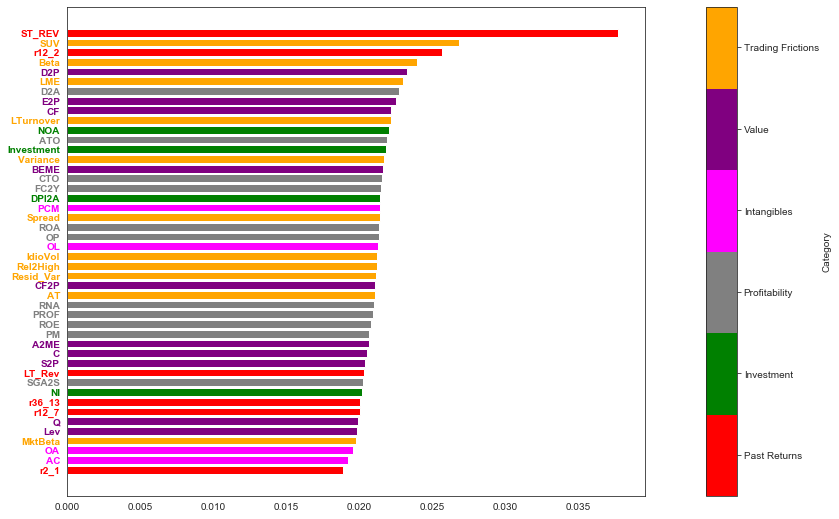

In [15]:
model_test.plotIndividualFeatureImportance(sess, dl_test, plotPath='plot', initial_state=INITIAL_test, top=46, figsize=(12,9))

Figure A.2

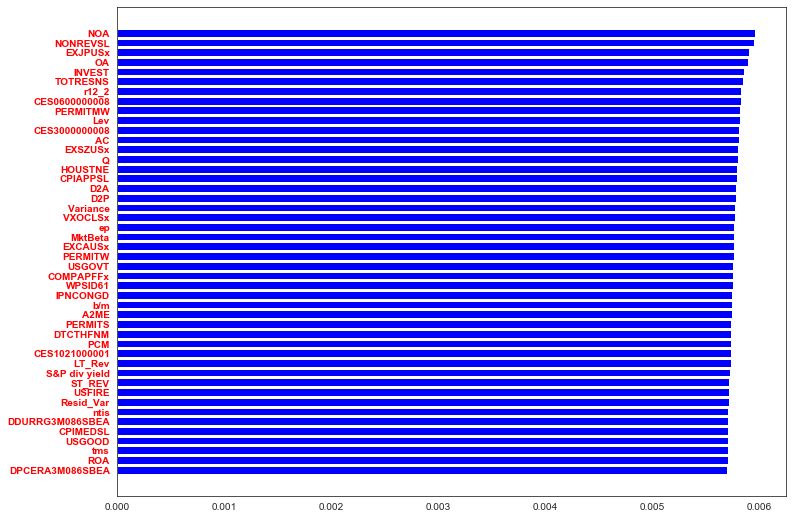

In [16]:
model_test.plotMacroFeatureImportance(sess, dl_test, plotPath='plot', initial_state=INITIAL_test, top=46, figsize=(12,9))

Figure 14

>==================> Please enter the idx for the plot you want! 
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_0/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_1/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_2/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_3/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_4/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_5/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_6/sharpe\model-best
>==================> Restored 

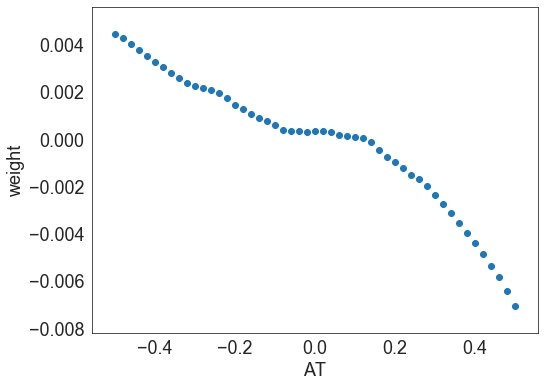

In [19]:
model_plot.plotWeight(sess, dl_test)

>==================> Please enter the idx for the plot you want! 
Please select from 1.1D, 2.2D Contour 3.2D Contour Slice 4.1D Curves (2 Variables) 5.1D Curves (3 Variables): 4
Enter variable idx for x (0 - 45, 46 - 223): 32
Enter variable idx for y (0 - 45, 46 - 223): 43
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_0/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_1/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_2/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_3/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_4/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_ch

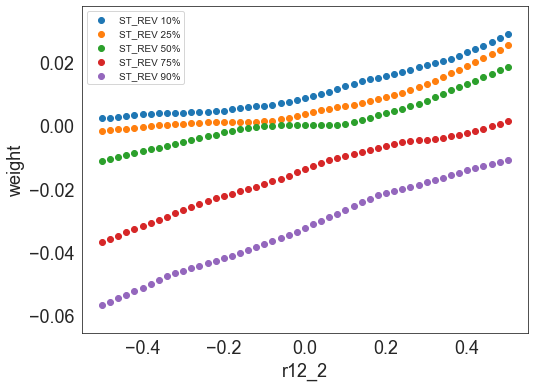

In [21]:
model_plot.plotWeight(sess, dl_test)

>==================> Please enter the idx for the plot you want! 
Please select from 1.1D, 2.2D Contour 3.2D Contour Slice 4.1D Curves (2 Variables) 5.1D Curves (3 Variables): 4
Enter variable idx for x (0 - 45, 46 - 223): 18
Enter variable idx for y (0 - 45, 46 - 223): 4
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_0/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_1/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_2/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_3/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_4/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_che

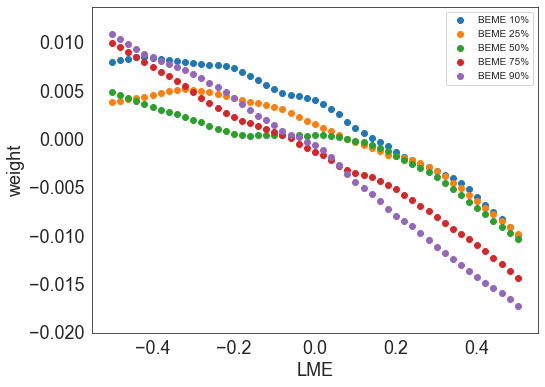

In [19]:
model_plot.plotWeight(sess, dl_test)

>==================> Please enter the idx for the plot you want! 
Please select from 1.1D, 2.2D Contour 3.2D Contour Slice 4.1D Curves (2 Variables) 5.1D Curves (3 Variables): 4
Enter variable idx for x (0 - 45, 46 - 223): 4
Enter variable idx for y (0 - 45, 46 - 223): 18
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_0/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_1/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_2/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_3/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_4/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_che

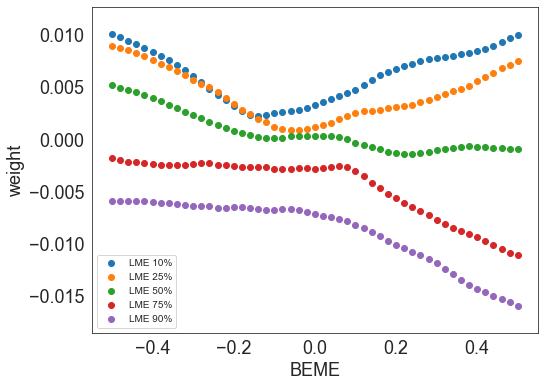

In [20]:
model_plot.plotWeight(sess, dl_test)

Figure 15

>==================> Please enter the idx for the plot you want! 
Please select from 1.1D, 2.2D Contour 3.2D Contour Slice 4.1D Curves (2 Variables) 5.1D Curves (3 Variables): 2
Enter variable idx for x (0 - 45, 46 - 223): 43
Enter variable idx for y (0 - 45, 46 - 223): 32
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_0/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_1/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_2/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_3/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_4/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_ch

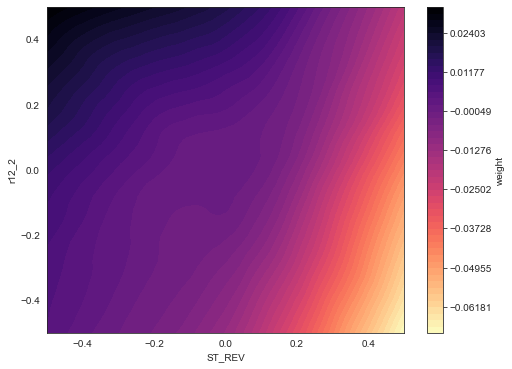

In [41]:
model_plot.plotWeight(sess, dl_test)

>==================> Please enter the idx for the plot you want! 
Please select from 1.1D, 2.2D Contour 3.2D Contour Slice 4.1D Curves (2 Variables) 5.1D Curves (3 Variables): 2
Enter variable idx for x (0 - 45, 46 - 223): 18
Enter variable idx for y (0 - 45, 46 - 223): 4
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_0/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_1/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_2/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_3/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_4/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_che

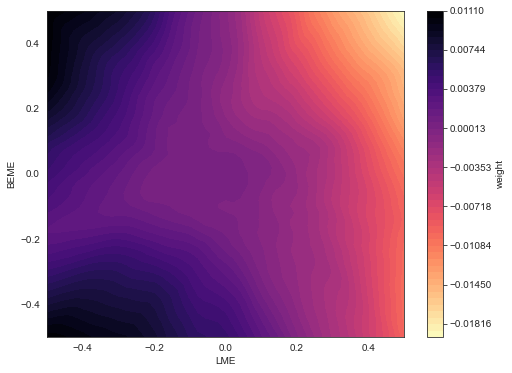

In [13]:
model_plot.plotWeight(sess, dl_test)

>==================> Please enter the idx for the plot you want! 
Please select from 1.1D, 2.2D Contour 3.2D Contour Slice 4.1D Curves (2 Variables) 5.1D Curves (3 Variables): 3
Enter variable idx for x (0 - 45, 46 - 223): 43
Enter variable idx for y (0 - 45, 46 - 223): 32
Enter variable idx for z (0 - 45, 46 - 223): 44
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_0/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_1/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_2/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_3/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_4/sharpe\model-best
>==================> Restored checkpoint
INF

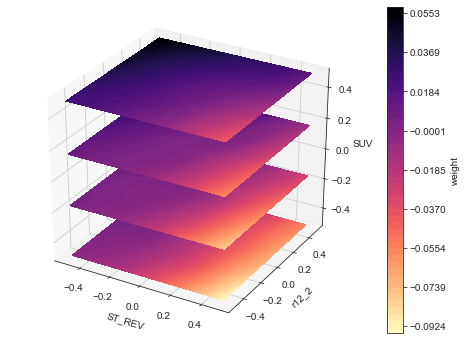

In [12]:
model_plot.plotWeight(sess, dl_test)

>==================> Please enter the idx for the plot you want! 
Please select from 1.1D, 2.2D Contour 3.2D Contour Slice 4.1D Curves (2 Variables) 5.1D Curves (3 Variables): 3
Enter variable idx for x (0 - 45, 46 - 223): 18
Enter variable idx for y (0 - 45, 46 - 223): 4
Enter variable idx for z (0 - 45, 46 - 223): 43
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_0/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_1/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_2/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_3/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_4/sharpe\model-best
>==================> Restored checkpoint
INFO

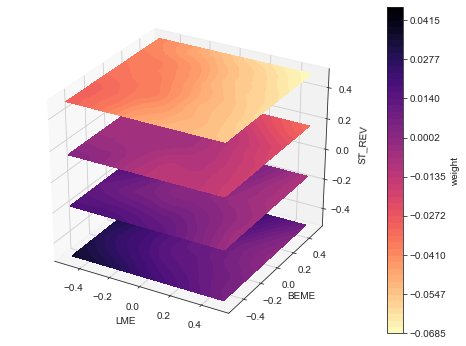

In [10]:
model_plot.plotWeight(sess, dl_test)

Figure 6

In [31]:
models = ['GAN (hidden state)', 'UNC', 'GAN (no macro)', 'FFN (no macro)', 'EN (no macro)', 'LS (no macro)', 'GAN (all macro)', 'FFN (all macro)', 'EN (all macro)', 'LS (all macro)']
SR = [[2.68, 1.43, 0.75],
     [1.93, 1.33, 0.53],
     [1.90, 1.35, 0.69],
     [0.45, 0.42, 0.44],
     [1.37, 1.15, 0.50],
     [1.80, 0.58, 0.42],
     [1.07, 0.05, 0.05],
     [1.46, 0.46, 0.21],
     [1.95, 0.54, 0.19],
     [2.63, 0.34, 0.10]]
df_SR = pd.DataFrame(SR, columns=['Training', 'Validation', 'Test'], index=models)
color_models = ['brown'] + ['red'] + ['orange'] * 4 + ['yellow'] * 4

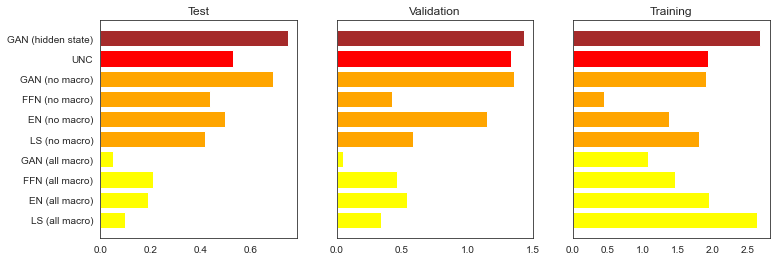

In [32]:
y_pos = np.arange(len(models))
fig = plt.figure(figsize=(12,4))

ax1 = plt.subplot(131)
ax1.barh(y_pos, df_SR.loc[:,'Test'].values, align='center', color=color_models)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(models)
ax1.invert_yaxis()
ax1.set_title('Test')

ax2 = plt.subplot(132)
ax2.barh(y_pos, df_SR.loc[:,'Validation'].values, align='center', color=color_models)
ax2.invert_yaxis()
ax2.set_yticks([])
ax2.set_title('Validation')

ax3 = plt.subplot(133)
ax3.barh(y_pos, df_SR.loc[:,'Training'].values, align='center', color=color_models)
ax3.invert_yaxis()
ax3.set_yticks([])
ax3.set_title('Training')
plt.show()

##### Beta Model Network

If you have completely trained a new set of checkpoints, you can use them to re-train the Beta Preidctive Model network, which involves re-generate R*F data and model training

In [30]:
# !python create_RF_data.py

In [4]:
# !python run_RtnFcst_ensembles.py --config config_RF --logdir output_RF --task_id 1 --trial_id 0

>==================> Read the following in config: 
{
    "individual_feature_file": "datasets/RF/RF_train_normalized_task_1.npz",
    "individual_feature_file_valid": "datasets/RF/RF_valid_normalized_task_1.npz",
    "individual_feature_file_test": "datasets/RF/RF_test_normalized_task_1.npz",
    "macro_feature_file": "datasets/macro/macro_train.npz",
    "macro_feature_file_valid": "datasets/macro/macro_valid.npz",
    "macro_feature_file_test": "datasets/macro/macro_test.npz",
    "sub_epoch": false,
    "macro_idx": [],
    "macro_feature_dim": 0,
    "individual_feature_dim": 46,
    "num_layers": 3,
    "hidden_dim": [
        32,
        16,
        8
    ],
    "dropout": 0.95,
    "mode": "train",
    "num_epochs": 2048,
    "loss_factor": 1.0,
    "weighted_loss": false,
    "optimizer": "Adam",
    "learning_rate": 0.001
}
>==================> Creating data layer
>==================> Data layer created
>==================> Trainable variables (scope=Model_Layer)
Name: Model_

2022-12-21 23:21:57.234819: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX AVX2
A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file output_RF\RF_1_Trial_0 already exists.
Error occurred while processing: output_RF\RF_1_Trial_0.
C:\Users\jason\anaconda3\envs\dlap-cpu\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\jason\anaconda3\envs\dlap-cpu\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Us

>==================> Epoch 896 Elapse/Estimate: 1900.25s/4338.58s



>==================> Doing epoch 1024
>==================> Epoch 1024 train/valid/test loss: 0.0170/0.0116/0.0237
>==================> Epoch 1024 train/valid/test sharpe: 0.8455/0.8004/0.4702
>==================> Epoch 1024 Elapse/Estimate: 2159.50s/4314.79s



>==================> Doing epoch 1152
>==================> Epoch 1152 train/valid/test loss: 0.0170/0.0116/0.0237
>==================> Epoch 1152 train/valid/test sharpe: 0.8464/0.7519/0.4825
>==================> Epoch 1152 Elapse/Estimate: 2418.69s/4296.16s



>==================> Doing epoch 1280
>==================> Epoch 1280 train/valid/test loss: 0.0169/0.0116/0.0237
>==================> Epoch 1280 train/valid/test sharpe: 0.8791/0.7742/0.4834
>==================> Epoch 1280 Elapse/Estimate: 2677.88s/4281.27s



>==================> Doing epoch 1408
>==================> Epoch 1408 train/valid/test loss: 0.0169/0.0116/0.0237
>==================> Epoch 1408

##### Predictive Performance

In [13]:
logdirs_RF = ['sample_checkpoints_RF/RF_%d_Trial_%d' %(task_id, k) for k in range(9)]
with open('config_RF/config_RF_%d.json'%(task_id)) as file:
    config_RF = json.load(file)

In [14]:
tf.reset_default_graph()
global_step = tf.train.get_or_create_global_step()
model_plot_RF = FeedForwardModelWithNA_Return_Ensembled(logdirs_RF, config_RF, 'plot', global_step=global_step)
gpu_options = tf.GPUOptions(allow_growth=True)
sess_config = tf.ConfigProto(gpu_options=gpu_options)
sess = tf.Session(config=sess_config)

In [15]:
dl_RF_train = data_layer.DataInRamInputLayer(config['individual_feature_file'])
dl_RF_valid = data_layer.DataInRamInputLayer(config['individual_feature_file_valid'])
dl_RF_test = data_layer.DataInRamInputLayer(config['individual_feature_file_test'])

In [16]:
beta_train = model_plot_RF.getPrediction(sess, dl_RF_train)
beta_valid = model_plot_RF.getPrediction(sess, dl_RF_valid)
beta_test = model_plot_RF.getPrediction(sess, dl_RF_test)

INFO:tensorflow:Restoring parameters from sample_checkpoints_RF/RF_1_Trial_0\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints_RF/RF_1_Trial_1\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints_RF/RF_1_Trial_2\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints_RF/RF_1_Trial_3\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints_RF/RF_1_Trial_4\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints_RF/RF_1_Trial_5\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints_RF/RF_1_Trial_6\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints_RF/RF_1_Trial_7\model-best
>========

In [17]:
# EV, XS-R2
EV_train, XSR2_train, WXSR2_train = calculateStatistics(beta_train, dl)
EV_valid, XSR2_valid, WXSR2_valid = calculateStatistics(beta_valid, dl_valid)
EV_test, XSR2_test, WXSR2_test = calculateStatistics(beta_test, dl_test)

GAN network EV and XS-R2 results reported in Table 1. The numbers are slightly different from the checkpoints used in the paper but numbers are very similar.

In [18]:
deco_print('Explained Variation: Train %0.2f\tValid %0.2f\tTest %0.2f' %(EV_train, EV_valid, EV_test))
deco_print('(Weighted) XS-R2: Train %0.2f\tValid %0.2f\tTest %0.2f' %(WXSR2_train, WXSR2_valid, WXSR2_test))

>==================> Explained Variation: Train 0.19	Valid 0.09	Test 0.07
>==================> (Weighted) XS-R2: Train 0.12	Valid 0.01	Test 0.22


In [19]:
decile = 10
for _, (I_macro, I, R, mask) in enumerate(dl.iterateOneEpoch(subEpoch=False)):
    portfolios_train = construct_decile_portfolios(beta_train, R, mask, decile=decile)
for _, (I_macro, I, R, mask) in enumerate(dl_valid.iterateOneEpoch(subEpoch=False)):
    portfolios_valid = construct_decile_portfolios(beta_valid, R, mask, decile=decile)
for _, (I_macro, I, R, mask) in enumerate(dl_test.iterateOneEpoch(subEpoch=False)):
    portfolios_test = construct_decile_portfolios(beta_test, R, mask, decile=decile)
df = pd.DataFrame(np.concatenate([portfolios_train, portfolios_valid, portfolios_test]), columns=['decile %d' %(k+1) for k in range(decile)])

Figure 7

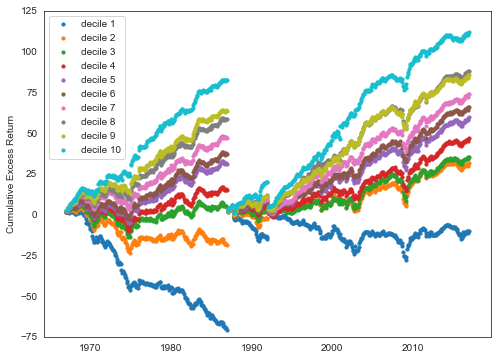

In [20]:
plot_decile_portfolios(df)

Figure 10

>==================> Plotting Variable: A2ME	Elapse / Estimate: 1.24s / 56.98s
>==================> Plotting Variable: AC	Elapse / Estimate: 2.47s / 56.87s
>==================> Plotting Variable: AT	Elapse / Estimate: 3.70s / 56.70s
>==================> Plotting Variable: ATO	Elapse / Estimate: 4.95s / 56.93s
>==================> Plotting Variable: BEME	Elapse / Estimate: 6.19s / 56.97s
>==================> Plotting Variable: Beta	Elapse / Estimate: 7.44s / 57.03s
>==================> Plotting Variable: C	Elapse / Estimate: 8.69s / 57.10s
>==================> Plotting Variable: CF	Elapse / Estimate: 9.92s / 57.05s
>==================> Plotting Variable: CF2P	Elapse / Estimate: 11.17s / 57.07s
>==================> Plotting Variable: CTO	Elapse / Estimate: 12.40s / 57.05s
>==================> Plotting Variable: D2A	Elapse / Estimate: 13.63s / 56.99s
>==================> Plotting Variable: D2P	Elapse / Estimate: 14.84s / 56.89s
>==================> Plotting Variable: DPI2A	Elapse / Estima

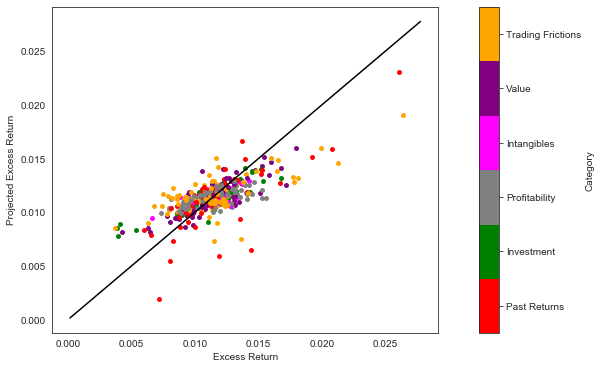

In [21]:
plotReturnDecile(dl_test, beta_test)